In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)


import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings 
warnings.filterwarnings('ignore')

Tensorflow version: 2.9.1


In [2]:
### Task 2: Plot Sample Images

In [3]:
def plot_example_images(plt):
    img_size = 48
    plt.figure(0, figsize=(12,20))
    ctr = 0
    for expression in os.listdir("train_2/"):
        for i in range(1,6):
            ctr += 1
            plt.subplot(7,5,ctr)
            img = load_img("train_2/" + expression + "/" +os.listdir("train_2/" + expression)[i], target_size=(img_size, img_size))
            plt.imshow(img, cmap="gray")

    plt.tight_layout()
    return plt

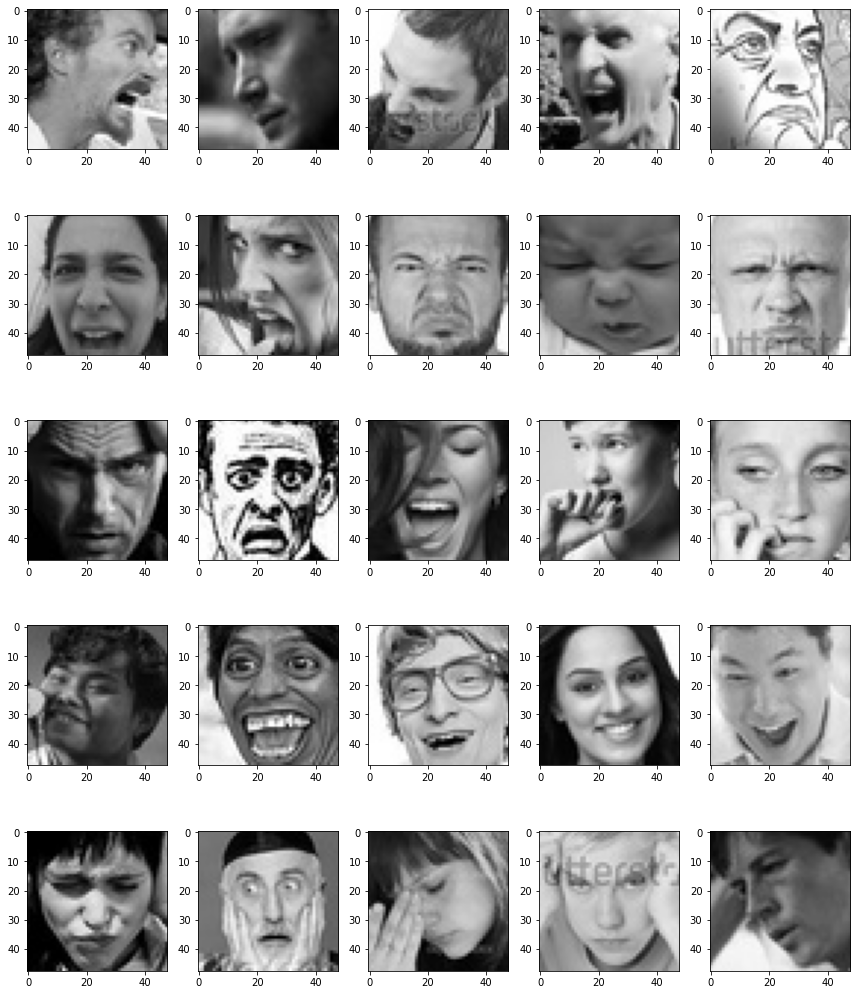

In [4]:
plot_example_images(plt).show()

In [5]:
for expression in os.listdir("train_2/"):
    print(str(len(os.listdir("train_2/" + expression))) + " " + expression + " images")

200 angry images
111 disgust images
228 fear images
200 happy images
180 sad images


In [6]:
### Task 3: Generate Training and Validation Batches

In [7]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory("train_2/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("train_2/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 919 images belonging to 5 classes.
Found 919 images belonging to 5 classes.


In [8]:
### Task 4: Create CNN Model

In [9]:
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(48,48,1), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(48,48,1)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(5))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))



from tensorflow.keras import optimizers
AlexNet.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0005), metrics=['accuracy'])

#Model Summary
AlexNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 12, 12, 96)        11712     
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 96)       384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 12, 12, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 6, 96)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 256)         614656    
                                                                 
 batch_normalization_1 (Batc  (None, 6, 6, 256)        1

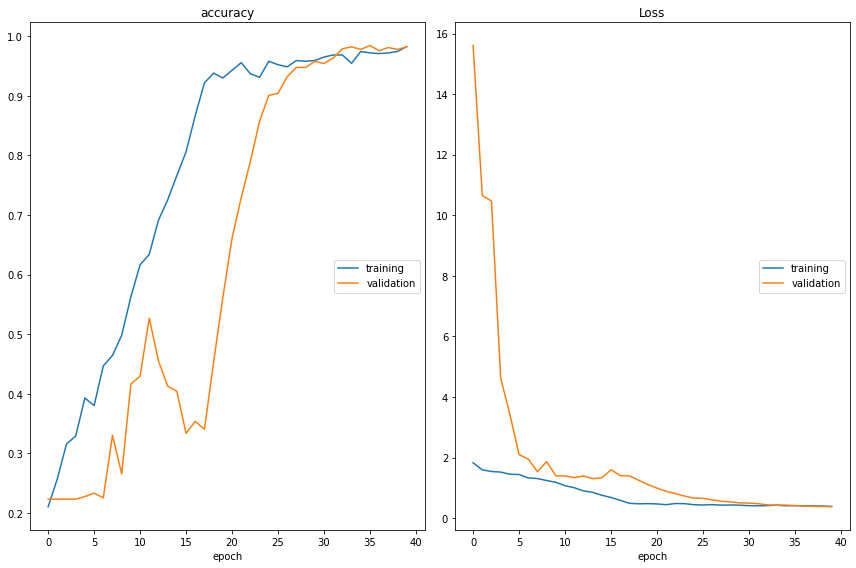

accuracy
	training         	 (min:    0.211, max:    0.982, cur:    0.982)
	validation       	 (min:    0.223, max:    0.984, cur:    0.982)
Loss
	training         	 (min:    0.385, max:    1.825, cur:    0.385)
	validation       	 (min:    0.375, max:   15.607, cur:    0.375)

Epoch 40: saving model to model_weights.h5
14/14 [==============================] - 30s 2s/step - loss: 0.3855 - accuracy: 0.9825 - val_loss: 0.3747 - val_accuracy: 0.9821 - lr: 1.0000e-05
Wall time: 20min 29s


In [10]:
%%time

epochs = 40
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = AlexNet.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

In [12]:
model_json = AlexNet.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)